# Angle-based Joint and Individual Variation (AJIVE) Explained

AJIVE is a useful algorithm that decomposes multiple views of data into three main categories:
- Joint Variation
- Individual Variation
- Noise

This notebook will prove out the implementation of AJIVE and show some examples of the algorithm's usefulness

In [2]:
import numpy as np
from mvlearn.decomposition.ajive import AJIVE, data_block_heatmaps, ajive_full_estimate_heatmaps
import matplotlib.pyplot as plt
%matplotlib inline

## Data Creation

Here we create data in the same way detailed in the initial JIVE paper:
<blockquote>
    [1] Lock, Eric F., et al. “Joint and Individual Variation Explained (JIVE) for Integrated Analysis of Multiple Data Types.”        The Annals of Applied Statistics, vol. 7, no. 1, 2013, pp. 523–542., doi:10.1214/12-aoas597.
</blockquote>

The two views are created with shared joint variation, unique individual variation, and independent noise. A representation of what the implementation of this algorithm does can be seen in the cell below.

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0047259X1730204X-gr1.jpg">


In [2]:
np.random.seed(12)

# First View
V1_joint = np.bmat([[-1 * np.ones((50, 2000))],
                       [np.ones((50, 2000))]])

V1_joint = np.bmat([np.zeros((100, 8000)), V1_joint])

V1_indiv_t = np.bmat([[np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))],
                        [np.zeros((20, 5000))],
                        [np.ones((20, 5000))],
                        [-1 * np.ones((20, 5000))]])

V1_indiv_b = np.bmat([[np.ones((25, 5000))],
                        [-1 * np.ones((50, 5000))],
                        [np.ones((25, 5000))]])

V1_indiv_tot = np.bmat([V1_indiv_t, V1_indiv_t])

V1_noise = np.random.normal(loc=0, scale=1, size=(100, 10000))


# Second View
V2_joint = np.bmat([[np.ones((50, 50))],
                      [-1*np.ones((50, 50))]])

V2_joint = 5000 * np.bmat([V2_joint, np.zeros((100, 50))])

V2_indiv = 5000 * np.bmat([[-1 * np.ones((25, 100))],
                              [np.ones((25, 100))],
                              [-1 * np.ones((25, 100))],
                              [np.ones((25, 100))]])

V2_noise = 5000 * np.random.normal(loc=0, scale=1, size=(100, 100))

# View Construction

V1 = V1_indiv_tot + V1_joint + V1_noise

V2 = V2_indiv + V2_joint + V2_noise

Views_1 = [V1, V1]
Views_2 = [V1, V2]

## Scree Plots

Scree plots allow us to observe variation and determine an appropriate initial signal rank for each view.

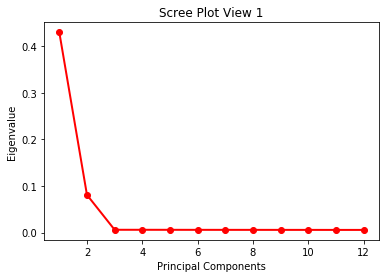

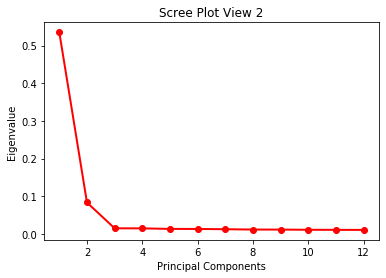

<Figure size 432x288 with 0 Axes>

In [3]:
def scree_plot(n,V,name):
    U, S, V = np.linalg.svd(V)
    eigvals = S**2 / np.sum(S**2)
    eigval_terms = np.arange(n) + 1
    plt.plot(eigval_terms, eigvals[0:n], 'ro-', linewidth=2)
    plt.title('Scree Plot '+ name)
    plt.xlabel('Principal Components')
    plt.ylabel('Eigenvalue')
    plt.figure()

scree_plot(12,V1,'View 1')
scree_plot(12,V2,'View 2')

Based on the scree plots, we fit AJIVE with both initial signal ranks set to 2.

In [4]:
ajive1 = AJIVE(init_signal_ranks=[2,2])
ajive1.fit(Xs=[V1,V1], view_names=['x1','x2'])

ajive2 = AJIVE(init_signal_ranks=[2,2])
ajive2.fit(Xs=[V1,V2], view_names=['x','y'])

joint rank: 1, block x indiv rank: 1, block y indiv rank: 1

## Output Structure

The predict() function returns n dictionaries where n is the number of views fitted. Each dictionary has a joint, individual, and noise matrix taken from the AJIVE decomposition. The keys are 'joint', 'individual', and 'noise' and the values are the respective matrices.


In [5]:
blocks1 = ajive1.predict()
blocks2 = ajive2.predict()

## Heatmap Visualizations

Here we are using heatmaps to visualize the decomposition of our views. As we can see when we use two of the same views there is no Individualized Variation displayed. When we create two different views, the algorithm finds different decompositions where common and individual structural artifacts can be seen in their corresponding heatmaps.

### Same Views

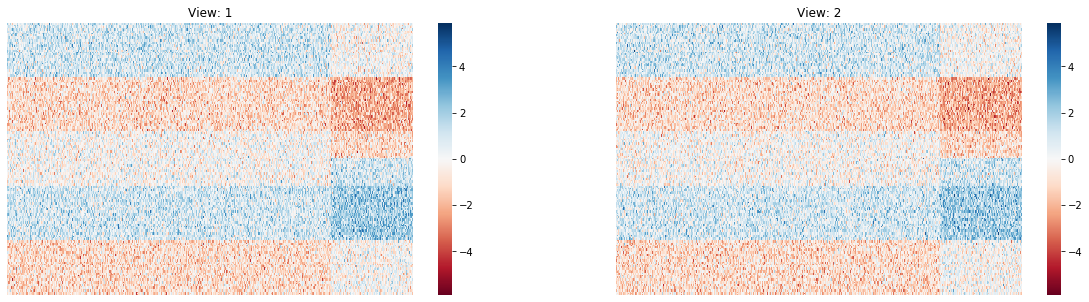

In [6]:
plt.figure(figsize=[20, 5])
data_block_heatmaps(Views_1)

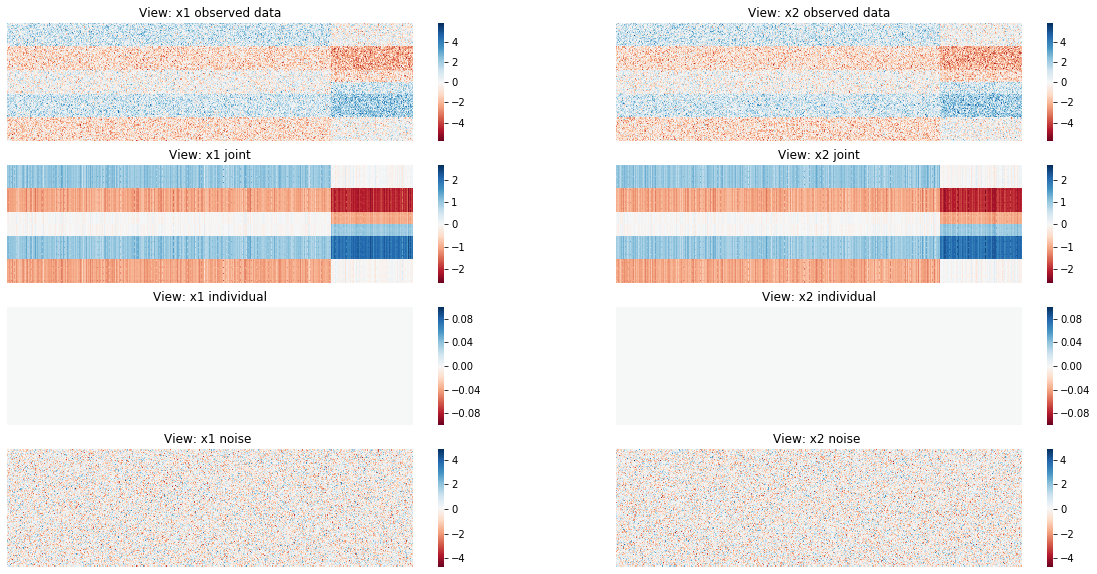

In [7]:
plt.figure(figsize=[20, 10])
plt.title('Same Views')
ajive_full_estimate_heatmaps(Views_1, blocks1, names=['x1','x2'])

### Different Views

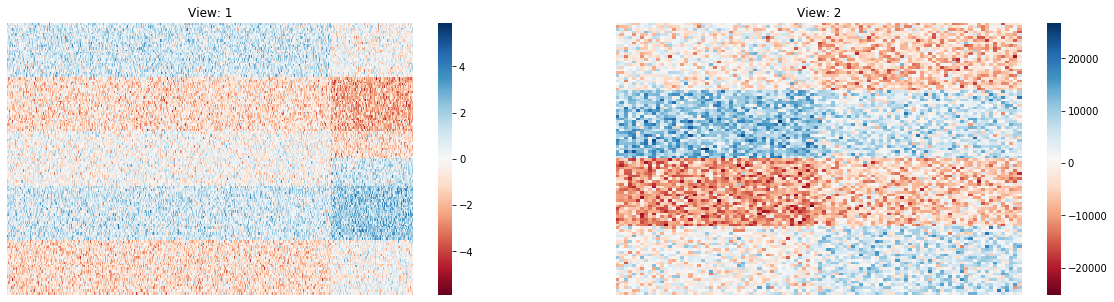

In [9]:
plt.figure(figsize=[20, 5])
data_block_heatmaps(Views_2)

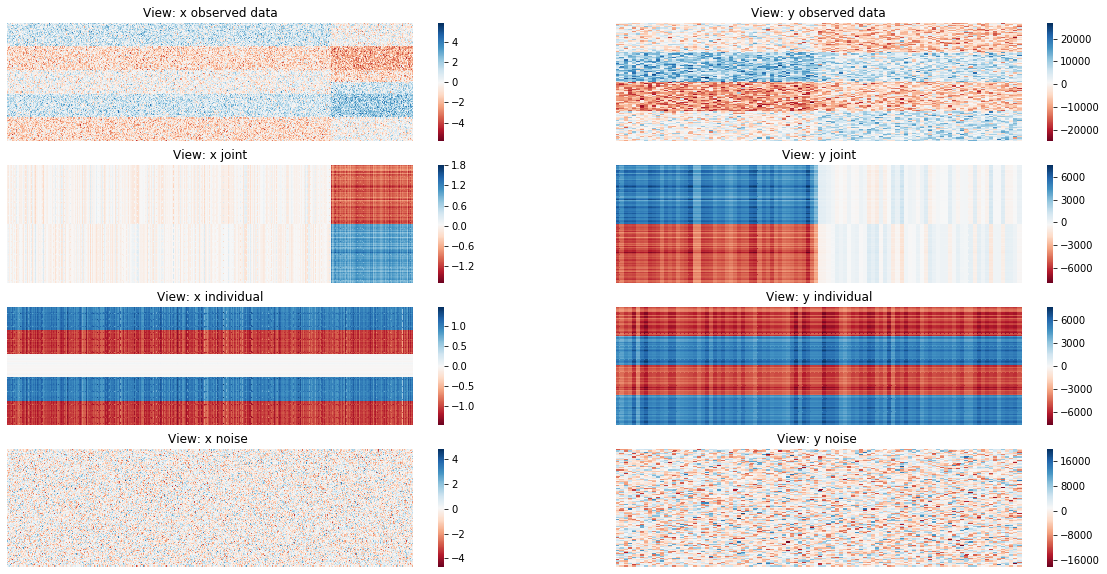

In [10]:
plt.figure(figsize=[20, 10])
ajive_full_estimate_heatmaps(Views_2, blocks2, names=['x','y'])